In [1]:
import os
import sys
sys.path.append(os.path.join(os.getcwd().replace("notebooks/pruning_quantization", "")))

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from config import Config
from data.dataset import NetworkDataset, load_datasets
from model_config import MLP_Models, LSTM_Models, GRU_Models, CNN_models
from compact.pruning import prune_mlp_model, prune_rnn_model, prune_cnn_model
from utils.plot import plot_fpr_tpr_roc_auc

In [ ]:
conf = Config()
#load_model = MLP_Models()
#load_model = LSTM_Models()
#load_model = GRU_Models()
load_model = CNN_models()
model_conf = load_model.cnn_4
model = load_model.get_model(model_conf)
model.load()
print(conf.device)

Checkpoint loaded from /global/D1/homes/jorgetf/Network-Packet-ML-Model/checkpoint/large_model/cnn_4.pth!
cuda


In [3]:
# data loader
X_train, y_train, X_val, y_val, X_test, y_test = load_datasets(conf.datasets, model_type=load_model.type)

# create train, val and test dataloaders
train_dataset = NetworkDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, conf.batch_size, shuffle=True)

val_dataset = NetworkDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, conf.batch_size, shuffle=True)

dataset = NetworkDataset(X_test, y_test)
loader = DataLoader(dataset, conf.batch_size, shuffle=True)

In [4]:
# prune model
checkpoint_path = os.path.join(conf.checkpoint, "pruned_quantized", "pruned_" + model_conf["name"] + ".pth")
model.checkpoint_path = checkpoint_path

# new hidden sizes
if load_model.type == "mlp":
    pruned_model = prune_mlp_model(model.model)
elif load_model.type == "rnn":
    pruned_model = prune_rnn_model(model.model)
elif load_model.type == "cnn":
    pruned_model = prune_cnn_model(model.model)
else:
    raise ValueError("model type must be 'mlp', 'rnn' or 'cnn'!")
    

model.model = pruned_model.to(conf.device)
model.optimizer = torch.optim.AdamW(
    model.model.parameters(), 
    lr=conf.learning_rate, 
    weight_decay=conf.weight_decay
)
model.scheduler = torch.optim.lr_scheduler.ExponentialLR(
    model.optimizer, 
    gamma=conf.gamma
)

In [5]:
# fine-tune pruned model
metrics, train_loss, val_loss = model.train(train_loader, val_loader, epochs=2)

Epoch: 1/2, Macro-F1 score: 0.71, Micro-F1 score: 0.89, Macro ROC AUC score: 0.98, Train loss: 0.253, Val loss: 0.141
Epoch: 2/2, Macro-F1 score: 0.73, Micro-F1 score: 0.90, Macro ROC AUC score: 0.98, Train loss: 0.133, Val loss: 0.121


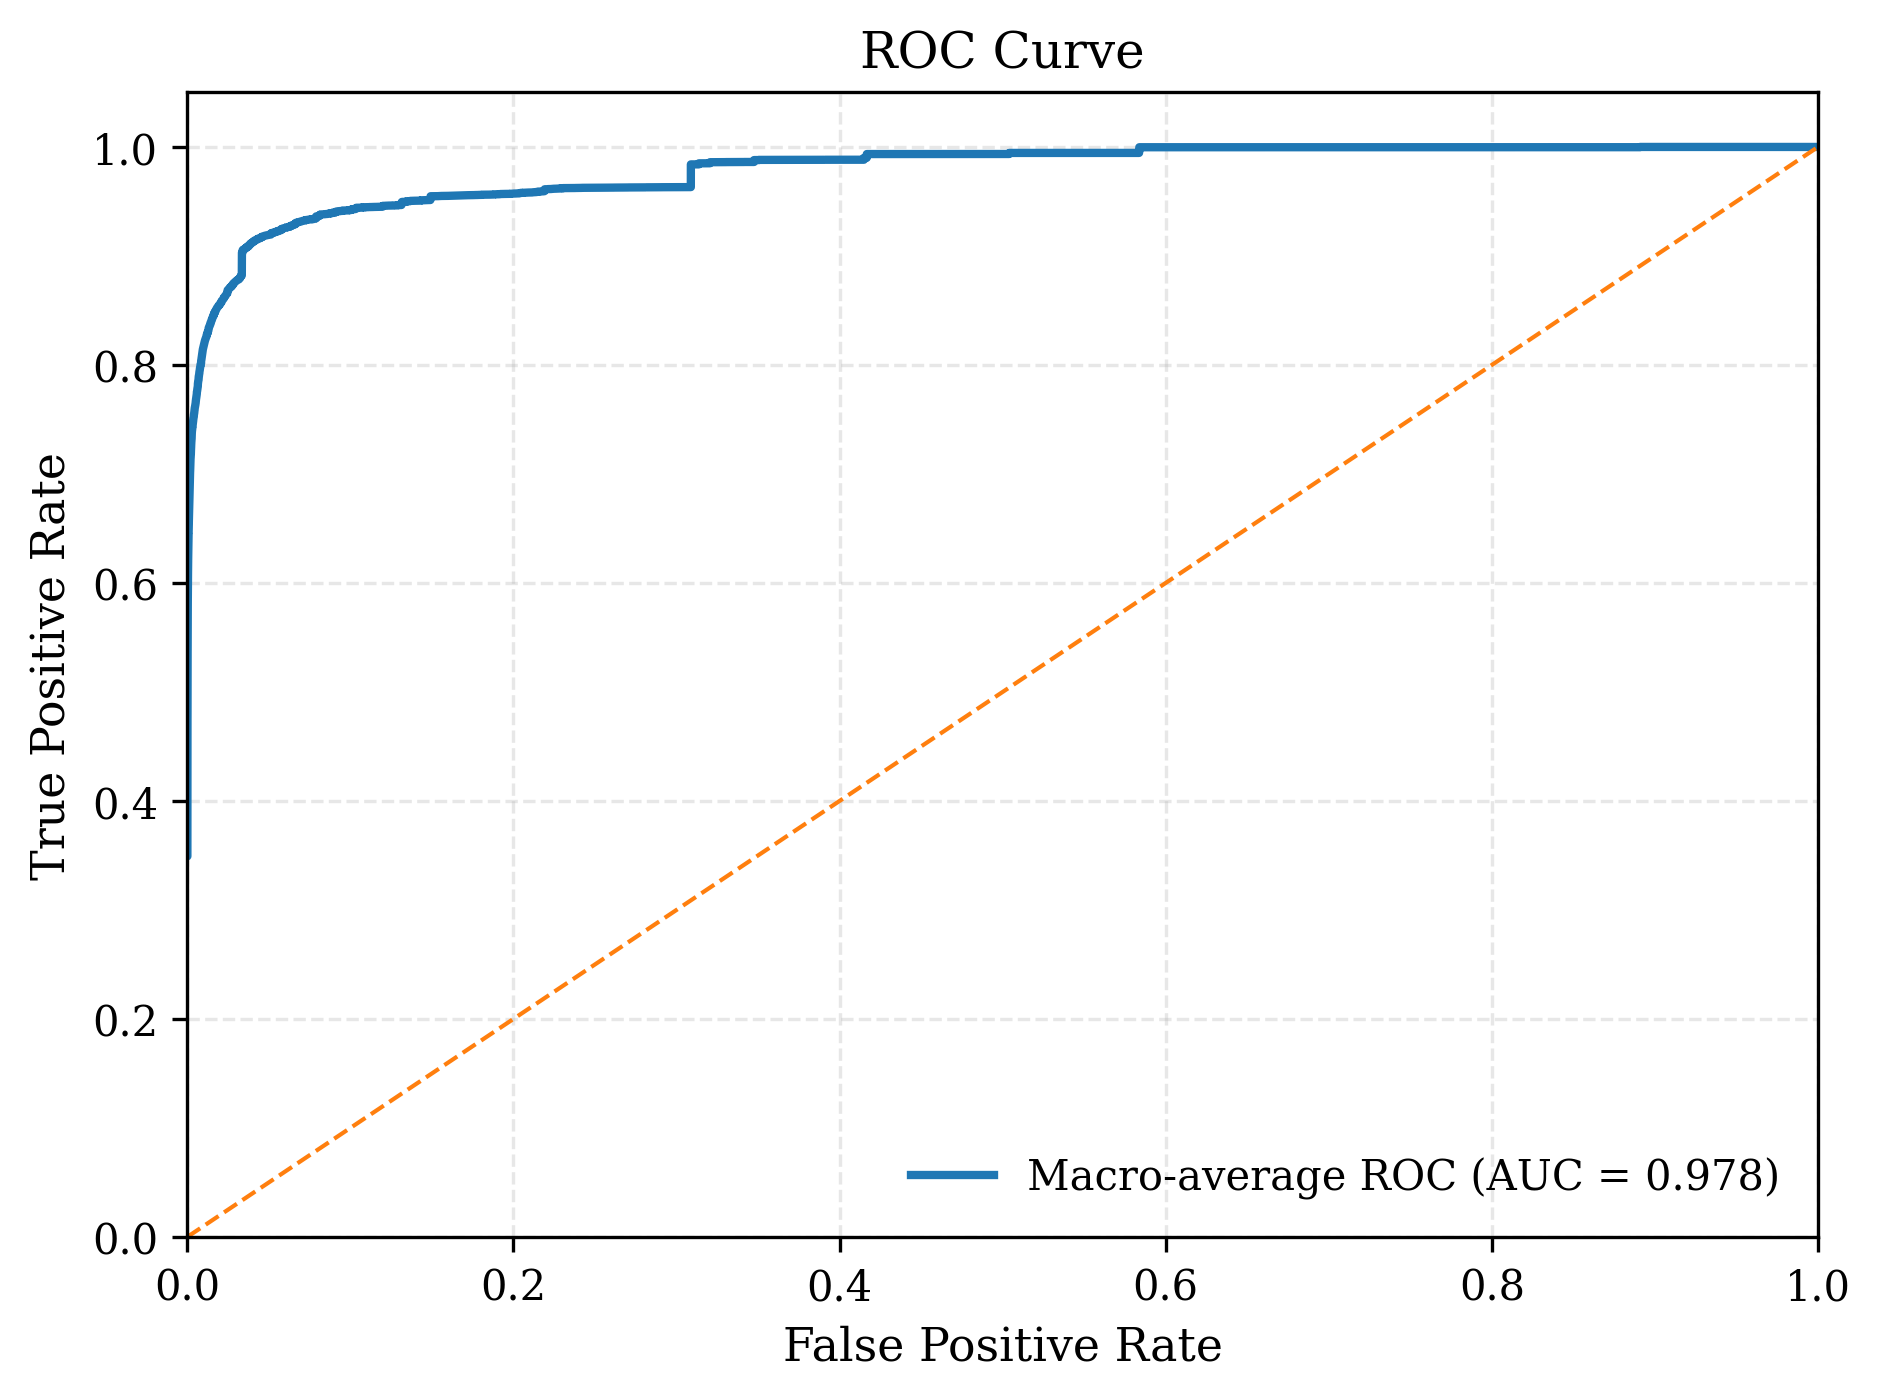

In [6]:
roc_auc_path = os.path.join(os.getcwd().replace("notebooks/pruning_quantization", ""), "plots", "pruning_quantization", "roc_auc_" + "pruned_" + model_conf["name"] + ".png")
plot_fpr_tpr_roc_auc(metrics[-1], roc_auc_path)

In [7]:
model.save()

Checkpoint saved at /global/D1/homes/jorgetf/Network-Packet-ML-Model/checkpoint/pruned_quantized/pruned_cnn_4.pth
